In [1]:
import torch
from helpers.ann_tools import *
import matplotlib.pyplot as plt
from helpers.computational_tools import select_LatLon
%load_ext autoreload
%autoreload 3

# Renaming coordinates to MOM6 convention

In [2]:
rename = {'xt_ocean': 'xh', 'yt_ocean': 'yh', 'xu_ocean': 'xq', 'yu_ocean': 'yq'}
rename_param = {'dxt': 'dxT', 'dyt': 'dyT', 'dxu': 'dxBu', 'dyu': 'dyBu'}

In [3]:
url = "gs://leap-persistent-ro/groundpepper/GFDL_cm2.6/GFDL_CM2_6_CONTROL_DAILY_SURF.zarr"
ds = xr.open_dataset(url, engine='zarr', chunks={}, use_cftime=True).rename(**rename).chunk({'yh':-1, 'yq':-1})

In [4]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
param_init  = cat["GFDL_CM2_6_grid"].to_dask().rename(**rename, **rename_param).chunk({'yh':-1, 'yq':-1})

param = xr.Dataset()
for key in ['xh', 'yh', 'xq', 'yq']:
    param[key] = param_init[key]
for key in ['dxT', 'dyT']:
    param[key] = param_init[key].drop(['area_t', 'dxT', 'dyT', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
for key in ['dxBu', 'dyBu']:
    param[key] = param_init[key].drop(['area_u', 'dxBu', 'dyBu', 'geolat_c', 'geolon_c', 'hu', 'kmu'])

In [5]:
param

<xarray.Dataset>
Dimensions:  (xh: 3600, yh: 2700, xq: 3600, yq: 2700)
Coordinates:
  * xh       (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * xq       (xq) float64 -279.9 -279.8 -279.7 -279.6 ... 79.7 79.8 79.9 80.0
  * yq       (yq) float64 -81.09 -81.05 -81.0 -80.96 ... 89.87 89.92 89.96 90.0
Data variables:
    dxT      (yh, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyT      (yh, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxBu     (yq, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyBu     (yq, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

# Creating mask of wet points

In [5]:
mask = 1 - np.isnan(ds.surface_salt).isel(time=-1).astype('float32').compute()

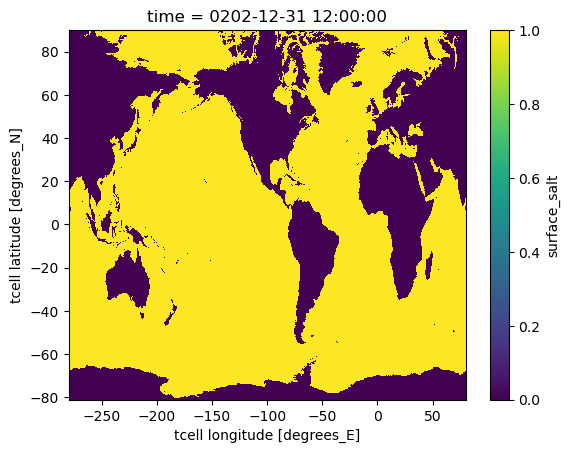

In [6]:
mask.plot()

# Check consistency of coordinates

Band of latitudes -60..60 does not have abrupt change of grid spacing

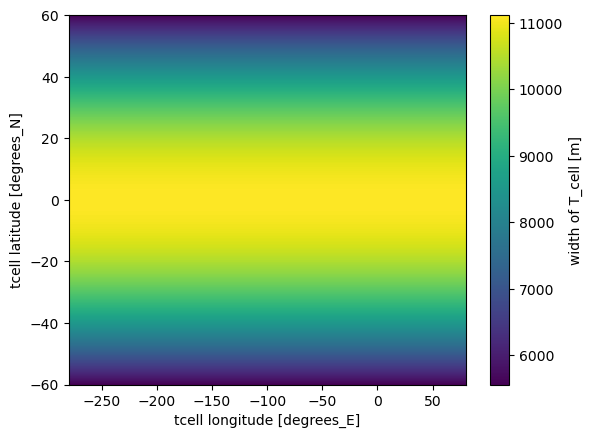

In [93]:
param.dxT.sel(yh=slice(-60,60)).plot()

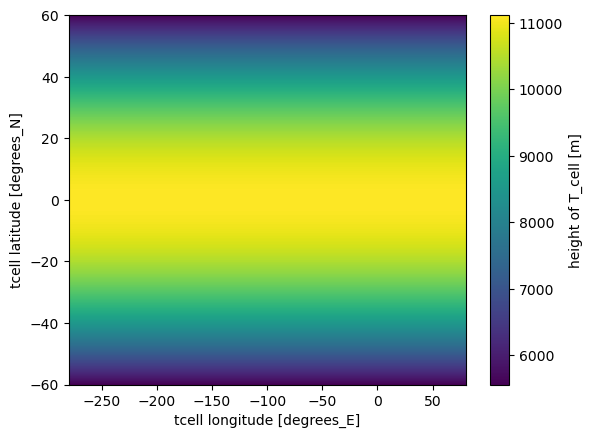

In [94]:
param.dyT.sel(yh=slice(-60,60)).plot()

# Computing grid information for C-grid

In [6]:
from xgcm import Grid

In [7]:
grid = Grid(param, coords={
            'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
            },
           boundary={"X": 'periodic', 'Y': 'fill'},
           fill_value = {'X':1e+20, 'Y':1e+20})

In [8]:
def mask_from_nans(variable):
    mask = (1 - np.isnan(variable).astype('float32'))
    if 'time' in variable.dims:
        mask = mask.isel(time=-1)
    if 'time' in variable.coords:
        mask = mask.drop('time')
    return mask

In [9]:
param['wet'] = mask_from_nans(ds.surface_salt)
param['wet_c'] = mask_from_nans(ds.usurf)
param['wet_u'] = mask_from_nans(grid.interp(ds.surface_salt,'X')) # We interpolate center variable as it gives best treatment of the coastline
param['wet_v'] = mask_from_nans(grid.interp(ds.surface_salt,'Y')) # We interpolate center variable as it gives best treatment of the coastline

In [10]:
def slice_NA(variable, time=None):
    x = select_LatLon(variable, Lat=(15, 65), Lon=(-90,-10))
    if 'time' in x.dims:
        if time is None:
            x = x.isel(time=-1)
        else:
            x = x.isel(time=time)
    return x

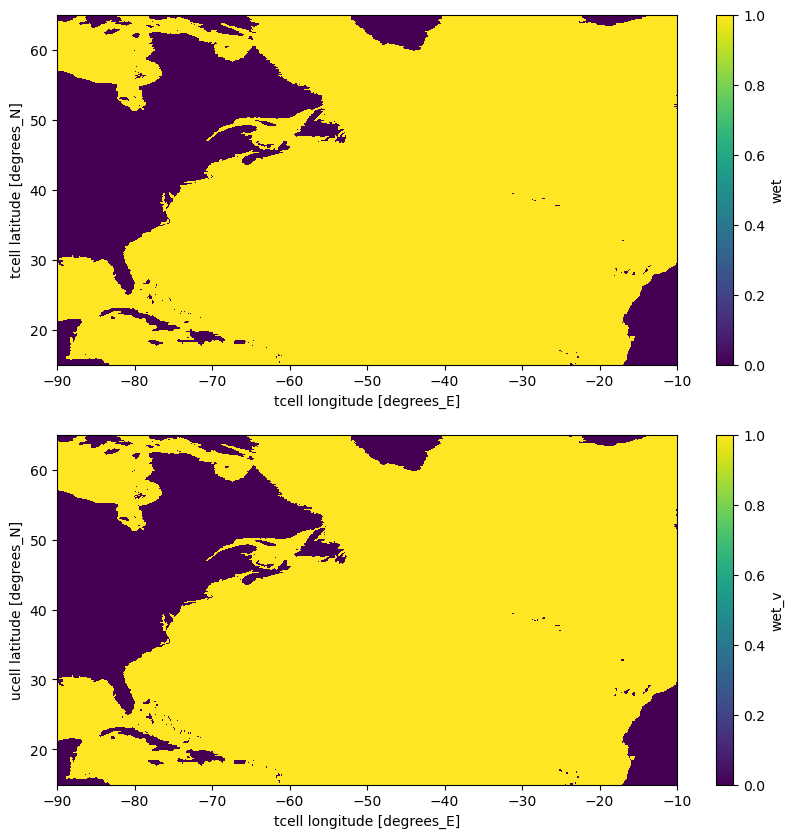

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
slice_NA(param.wet).plot()
plt.subplot(2,1,2)
slice_NA(param.wet_v).plot()

# Computing grid steps in staggered points

In [12]:
param['dxCu'] = grid.interp(param.dxT,'X')
param['dyCu'] = grid.interp(param.dyT,'X')
param['dxCv'] = grid.interp(param.dxT,'Y')
param['dyCv'] = grid.interp(param.dyT,'Y')

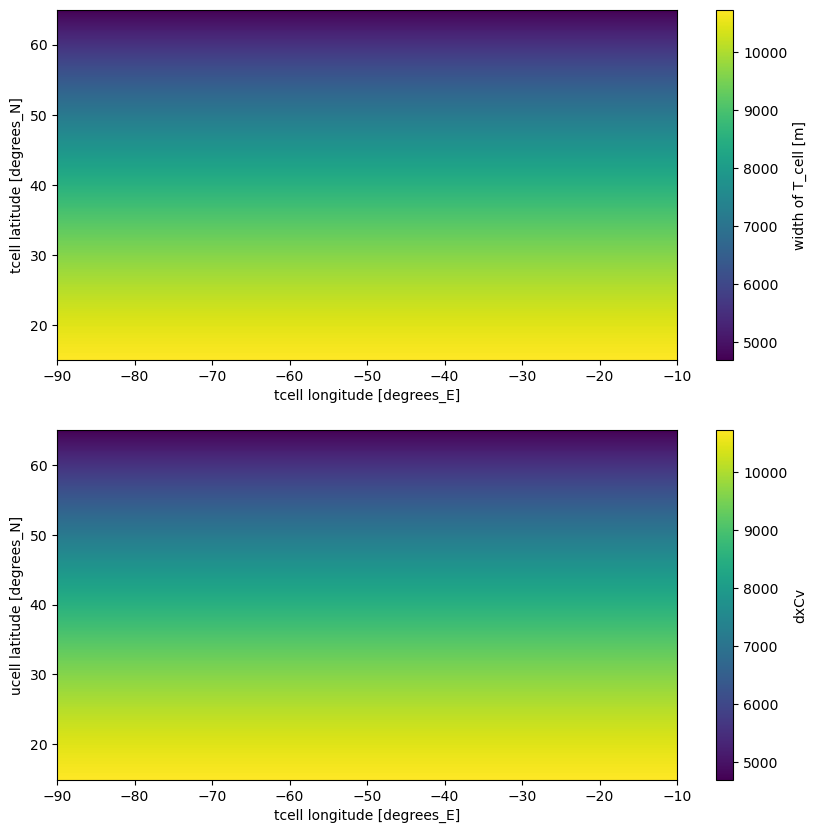

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
slice_NA(param.dxT).plot()
plt.subplot(2,1,2)
slice_NA(param.dxCv).plot()

In [17]:
param

<xarray.Dataset>
Dimensions:  (xh: 3600, yh: 2700, xq: 3600, yq: 2700)
Coordinates:
  * xh       (xh) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * xq       (xq) float64 -279.9 -279.8 -279.7 -279.6 ... 79.7 79.8 79.9 80.0
  * yq       (yq) float64 -81.09 -81.05 -81.0 -80.96 ... 89.87 89.92 89.96 90.0
Data variables:
    dxT      (yh, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyT      (yh, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxBu     (yq, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyBu     (yq, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet      (yh, xh) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet_c    (yq, xq) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet_u    (yh, xq) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet_v    (yq, xh) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxCu     (yh, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyCu     (yh, xq) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxCv     (yq, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyCv     (yq, xh) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

# Interpolating data to C grid

In [14]:
data = xr.Dataset()

In [15]:
data['u'] = grid.interp(ds.usurf,'Y').fillna(0.)
data['v'] = grid.interp(ds.vsurf,'X').fillna(0.)

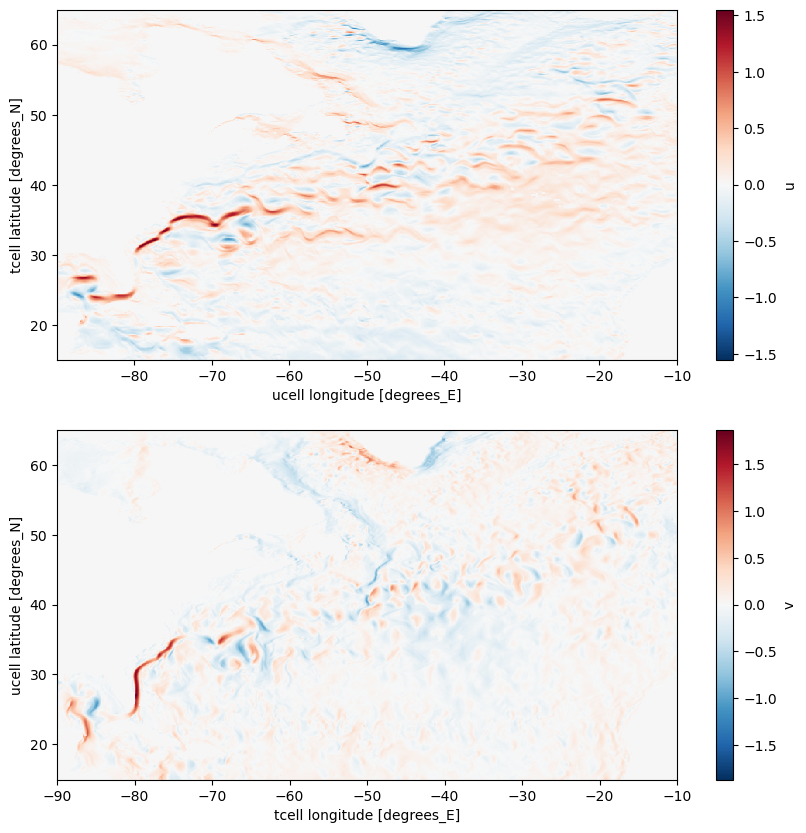

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
slice_NA(data.u).plot()
plt.subplot(2,1,2)
slice_NA(data.v).plot()

# Computing Zanna-Bolton

In [33]:
def ZB20(mom, param, ZB_scaling=1.0):
    
    grid = Grid(param, coords={
                'X': {'center': 'xh', 'right': 'xq'},
                'Y': {'center': 'yh', 'right': 'yq'}
                },
                boundary={'X':'periodic', 'Y':'fill'},
                fill_value = {'X':0, 'Y':0}
                )
    
    dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
    dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
    
    dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
    dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c
    
    sh_xx = dudx-dvdy
    sh_xy = dvdx+dudy
    vort_xy=dvdx-dudy
        
    vort_xy_center = grid.interp(vort_xy,['X','Y']) * param.wet
    sh_xy_center = grid.interp(sh_xy,['X','Y']) * param.wet
    sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c
    
    vort_sh = vort_xy_center * sh_xy_center
        
    sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
        
    kappa_t = - param.dxT * param.dyT * param.wet * ZB_scaling
    kappa_q = - param.dxBu * param.dyBu * param.wet_c * ZB_scaling
        
        
    Txx = kappa_t * (- vort_sh + sum_sq)
    Tyy = kappa_t * (+ vort_sh + sum_sq)
    Txy = kappa_q * (vort_xy * sh_xx_corner)
    
    from xgcm.grid_ufunc import as_grid_ufunc
    @as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,1)})
    def prod_ufunc(a):
        return a[...,:-1] * a[...,1:]
    
    ZB2020u = param.wet_u * (grid.diff(Txx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(Txy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu)

    ZB2020v = param.wet_v * (grid.diff(Txy*param.dyBu**2, 'X') / param.dyCv     \
               + grid.diff(Tyy*param.dxT**2, 'Y') / param.dxCv) \
               / (param.dxCv*param.dyCv)
        
    return {'ZB2020u': ZB2020u, 'ZB2020v': ZB2020v, 
            'Txx': Txx, 'Tyy': Tyy, 'Txy': Txy}

In [34]:
zb = ZB20(data,param)

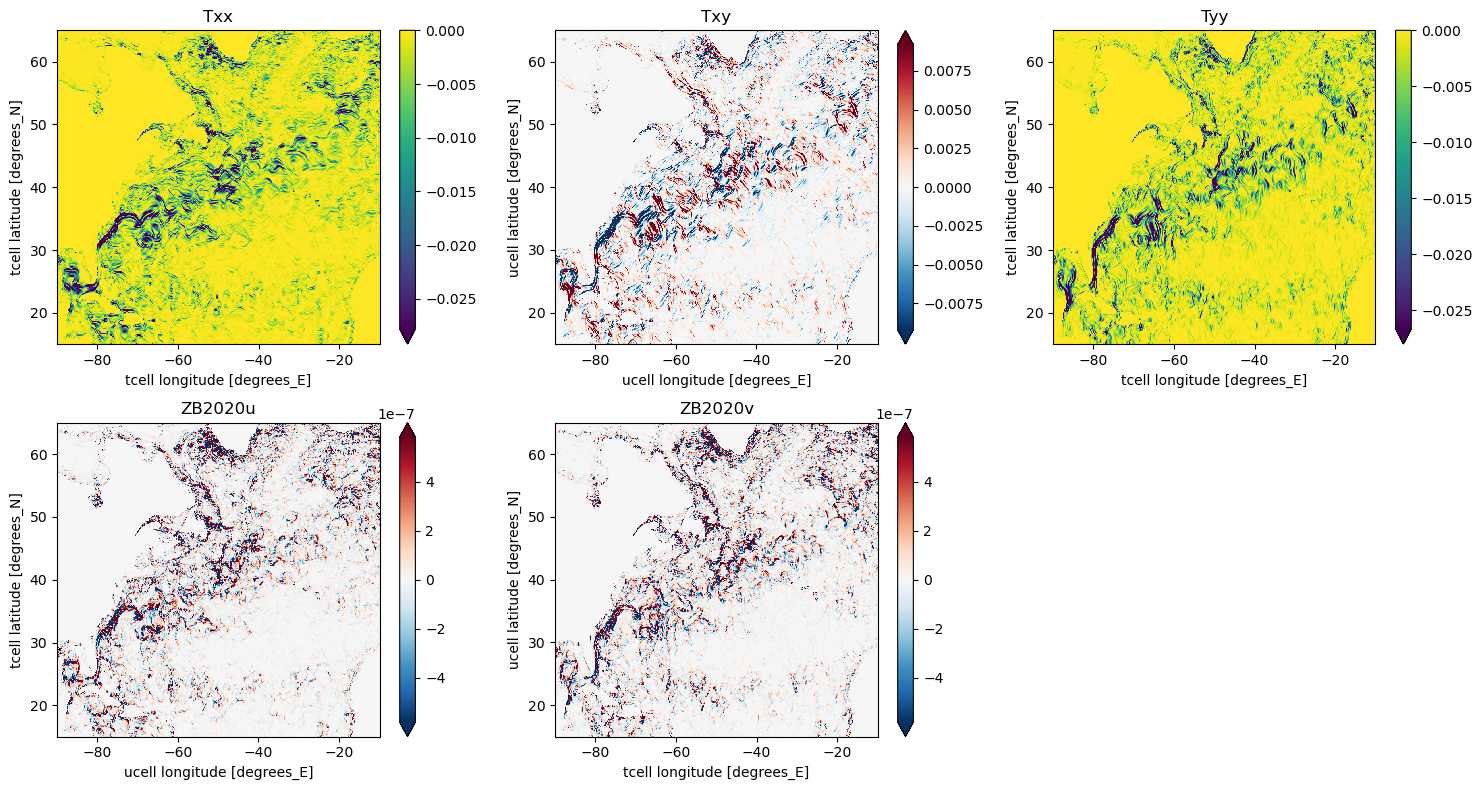

In [40]:
plt.figure(figsize=(15,8))
for j,key in enumerate(['Txx', 'Txy', 'Tyy', 'ZB2020u', 'ZB2020v']):
    plt.subplot(2,3,j+1)
    slice_NA(zb[key]).plot(robust=True)
    plt.title(key)
plt.tight_layout()
plt.savefig('ZB-NA.png', dpi=300)